#单位区和功能区分类

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [2]:
# 设置超参数
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 数据增强和预处理
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# 数据加载
data_dir = '../../images_dataset_resnet_train/0'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 打印所使用的设备
print(f'Using device: {device}')

Using device: cuda:0


In [5]:

# 定义模型
weights = ResNet50_Weights.IMAGENET1K_V1  # 或者使用 ResNet50_Weights.DEFAULT
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# 训练模型
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return model


In [6]:
# 训练和验证模型
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 1.2432 Acc: 0.7043
val Loss: 0.1550 Acc: 0.9680
Epoch 2/10
----------
train Loss: 0.2235 Acc: 0.9495
val Loss: 0.0354 Acc: 0.9948
Epoch 3/10
----------
train Loss: 0.1149 Acc: 0.9735
val Loss: 0.0110 Acc: 1.0000
Epoch 4/10
----------
train Loss: 0.0836 Acc: 0.9792
val Loss: 0.0085 Acc: 0.9993
Epoch 5/10
----------
train Loss: 0.0648 Acc: 0.9845
val Loss: 0.0056 Acc: 1.0000
Epoch 6/10
----------
train Loss: 0.0527 Acc: 0.9875
val Loss: 0.0029 Acc: 1.0000
Epoch 7/10
----------
train Loss: 0.0458 Acc: 0.9879
val Loss: 0.0024 Acc: 0.9993
Epoch 8/10
----------
train Loss: 0.0376 Acc: 0.9909
val Loss: 0.0015 Acc: 1.0000
Epoch 9/10
----------
train Loss: 0.0362 Acc: 0.9908
val Loss: 0.0019 Acc: 1.0000
Epoch 10/10
----------
train Loss: 0.0326 Acc: 0.9916
val Loss: 0.0011 Acc: 1.0000


In [7]:
# 保存模型
torch.save(model_ft.state_dict(), 'resnet50_unit.pth')

In [9]:
# 加载保存的模型
model_ft = models.resnet50(weights=None)  # 初始化模型
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # 替换最后一层
model_ft.load_state_dict(torch.load('resnet50_unit.pth'))  # 加载训练好的权重
model_ft = model_ft.to(device)
model_ft.eval()  # 设置模型为评估模式

# 定义图片预处理步骤
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

The predicted class for the image is: 0-北京公联


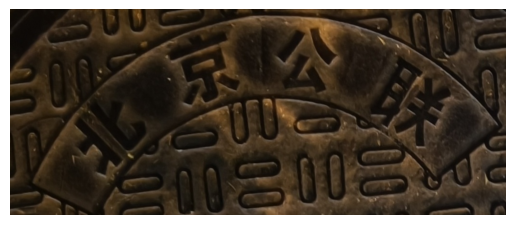

In [20]:
# 导入图片并预处理
img_path = '../../resnet_class_backup/origin/0/0-北京公联/0-北京公联_IMG_20240629_003830_target_0.jpg'

input_image = Image.open(img_path)
input_tensor = preprocess(input_image)
input_tensor = input_tensor.unsqueeze(0)  # 增加一个batch维度
input_tensor = input_tensor.to(device)

# 进行推理
with torch.no_grad():
    output = model_ft(input_tensor)
    _, preds = torch.max(output, 1)
    predicted_class = class_names[preds[0]]

print(f'The predicted class for the image is: {predicted_class}')

# 显示原始图片
plt.imshow(input_image)
plt.axis('off')  # 不显示坐标轴
plt.show()

              precision    recall  f1-score   support

 0-中关村信息工程公司       1.00      1.00      1.00         4
      0-中国联通       1.00      1.00      1.00         1
      0-交通设施       1.00      1.00      1.00         1
   0-公安交通管理局       1.00      1.00      1.00         1
      0-北京供电       1.00      1.00      1.00         8
     0-北京供电局       1.00      1.00      1.00         2
      0-北京公联       1.00      1.00      1.00         2
   0-北京市人民政府       1.00      1.00      1.00         1
0-北京市公安交通管理局       1.00      1.00      1.00         4
  0-北京市市政工程局       1.00      1.00      1.00         6
      0-北京市政       1.00      1.00      1.00        27
    0-北京市政工程       1.00      1.00      1.00         5
   0-北京市热力公司       1.00      1.00      1.00         3
   0-北京市电信公司       1.00      1.00      1.00         4
  0-北京市自来水公司       1.00      1.00      1.00         3
  0-北京市自来水集团       1.00      1.00      1.00        21
  0-北京市路灯管理处       1.00      1.00      1.00         4
    0-北京排水集团       1.00    

/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26449 (\N{CJK UNIFIED IDEOGRAPH-6751}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 24687 (\N{CJK UNIFIED IDEOGRAPH-606F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/u20212135

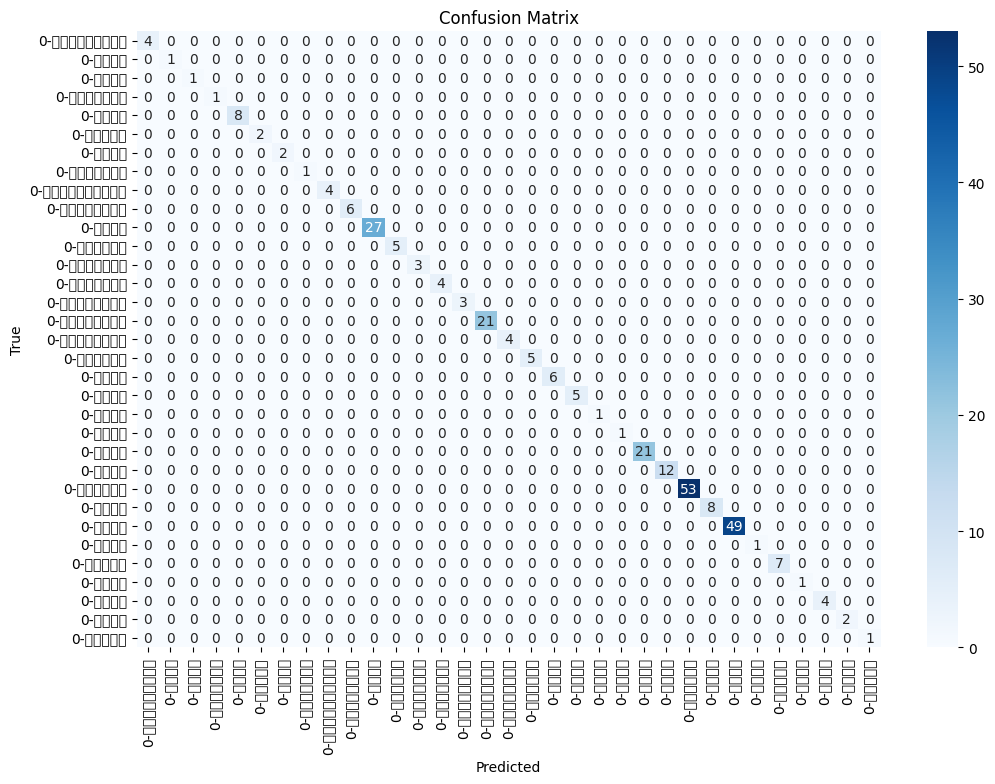

In [22]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义数据预处理步骤
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 加载测试集
data_dir = '../../resnet_class_backup/origin/0'
image_datasets = datasets.ImageFolder(data_dir, data_transforms['test'])
dataloaders = DataLoader(image_datasets, batch_size=32, shuffle=False, num_workers=4)
class_names = image_datasets.classes

# 加载模型
model_ft = models.resnet50(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load('resnet50_unit.pth'))
model_ft = model_ft.to(device)
model_ft.eval()

# 定义测试函数
def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# 评估模型
true_labels, pred_labels = evaluate_model(model_ft, dataloaders)

# 打印分类报告
print(classification_report(true_labels, pred_labels, target_names=class_names))

# 绘制混淆矩阵
conf_mat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
